# Feature Correlation Analysis

This notebook analyzes the correlation between gene expression and copy number variation. Samples are split into subgroups (normal, amplified, deleted) to isolate any patterns in gene expression data related to copy number status.

The following samples are used:
- C3L-02705-71
- C3N-00148-01
- C3N-00148-04

Note that there is a class imbalance among the samples where normal and amplified results are much more strongly represented than deleted.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, kstest

Retrieve copy number and gene expression data for each sample:

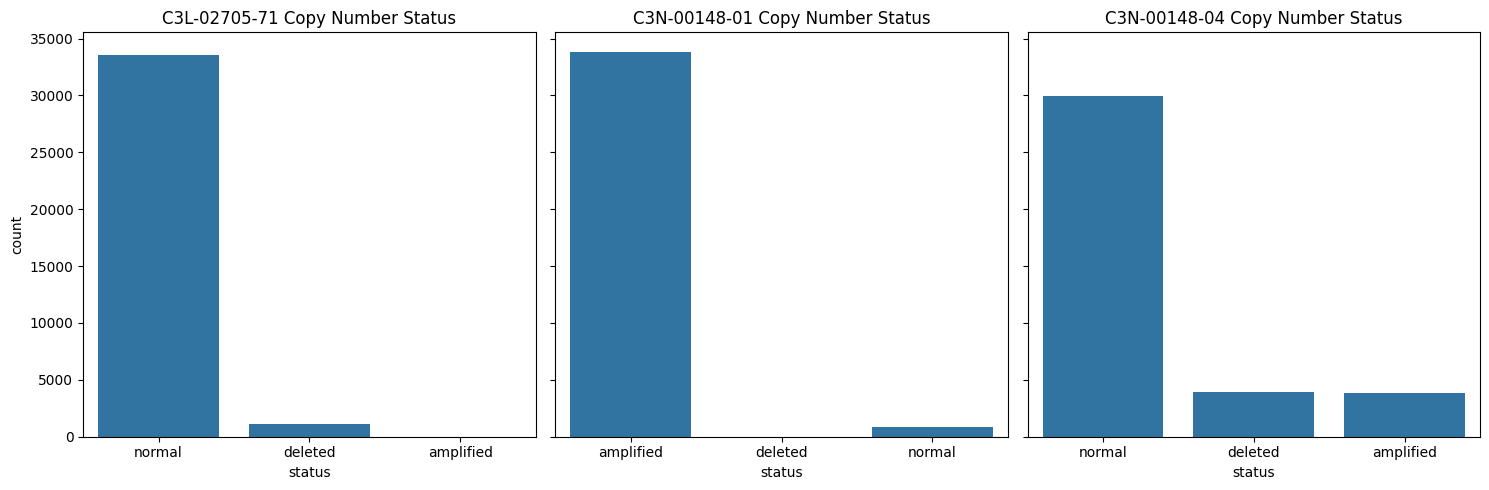

In [2]:
s1_case_id = 'C3L-02705-71'
s2_case_id = 'C3N-00148-01'
s3_case_id = 'C3N-00148-04'

# load datasets
s1_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3L-02705-71.csv')
s2_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3N-00148-01.csv')
s3_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/dataset/C3N-00148-04.csv')

# drop rows with zeroed stats
s1_df = s1_df[(s1_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] != 0).all(axis=1)]
s2_df = s2_df[(s2_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] != 0).all(axis=1)]
s3_df = s3_df[(s3_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] != 0).all(axis=1)]

# set up figure and axes for plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# plot for sample 1
sns.countplot(data=s1_df, x='status', ax=axes[0])
axes[0].set_title(f'{s1_case_id} Copy Number Status')

# plot for sample 2
sns.countplot(data=s2_df, x='status', ax=axes[1])
axes[1].set_title(f'{s2_case_id} Copy Number Status')

# plot for sample 3
sns.countplot(data=s3_df, x='status', ax=axes[2])
axes[2].set_title(f'{s3_case_id} Copy Number Status')

# side by side display
plt.tight_layout()
plt.show()

Description lists for plots

In [3]:
samples = [s1_df, s2_df, s3_df]
sample_names = ["s1", "s2", "s3"]
stats = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']
dev_stats = ['dev_gene_expr_normalized_mean', 'dev_mean_gene_expr_normalized_mean', 'dev_variance_gene_expr_normalized_mean']

# status to color mapping
status_colors = {
    "normal": "green",
    "amplified": "blue",
    "deleted": "red"
}

Interquartile range calculation to remove outliers

In [4]:
# helper function to remove outliers via IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

## Gene expression sum, mean, variance (post-log transform)

- Separate histograms are created for clearer view of the varying distribution ranges Displaying log transformed distributions.
- The `split_stats` dictionary is also used to track each feature's raw values as they appear in the plots. Keys names are based on the sample, CNV status, and statistic. Values are the contents of the feature (column) for a specific CNV status (normal/amplified/deleted) in a sample. This dictionary is used for K-S tests.

Keys:
- **Samples**: s1, s2, or s3
- **CNV status**: normal, amplified, deleted
- **Statistic**: sum_gene_expr, mean_gene_expr, variance_gene_expr

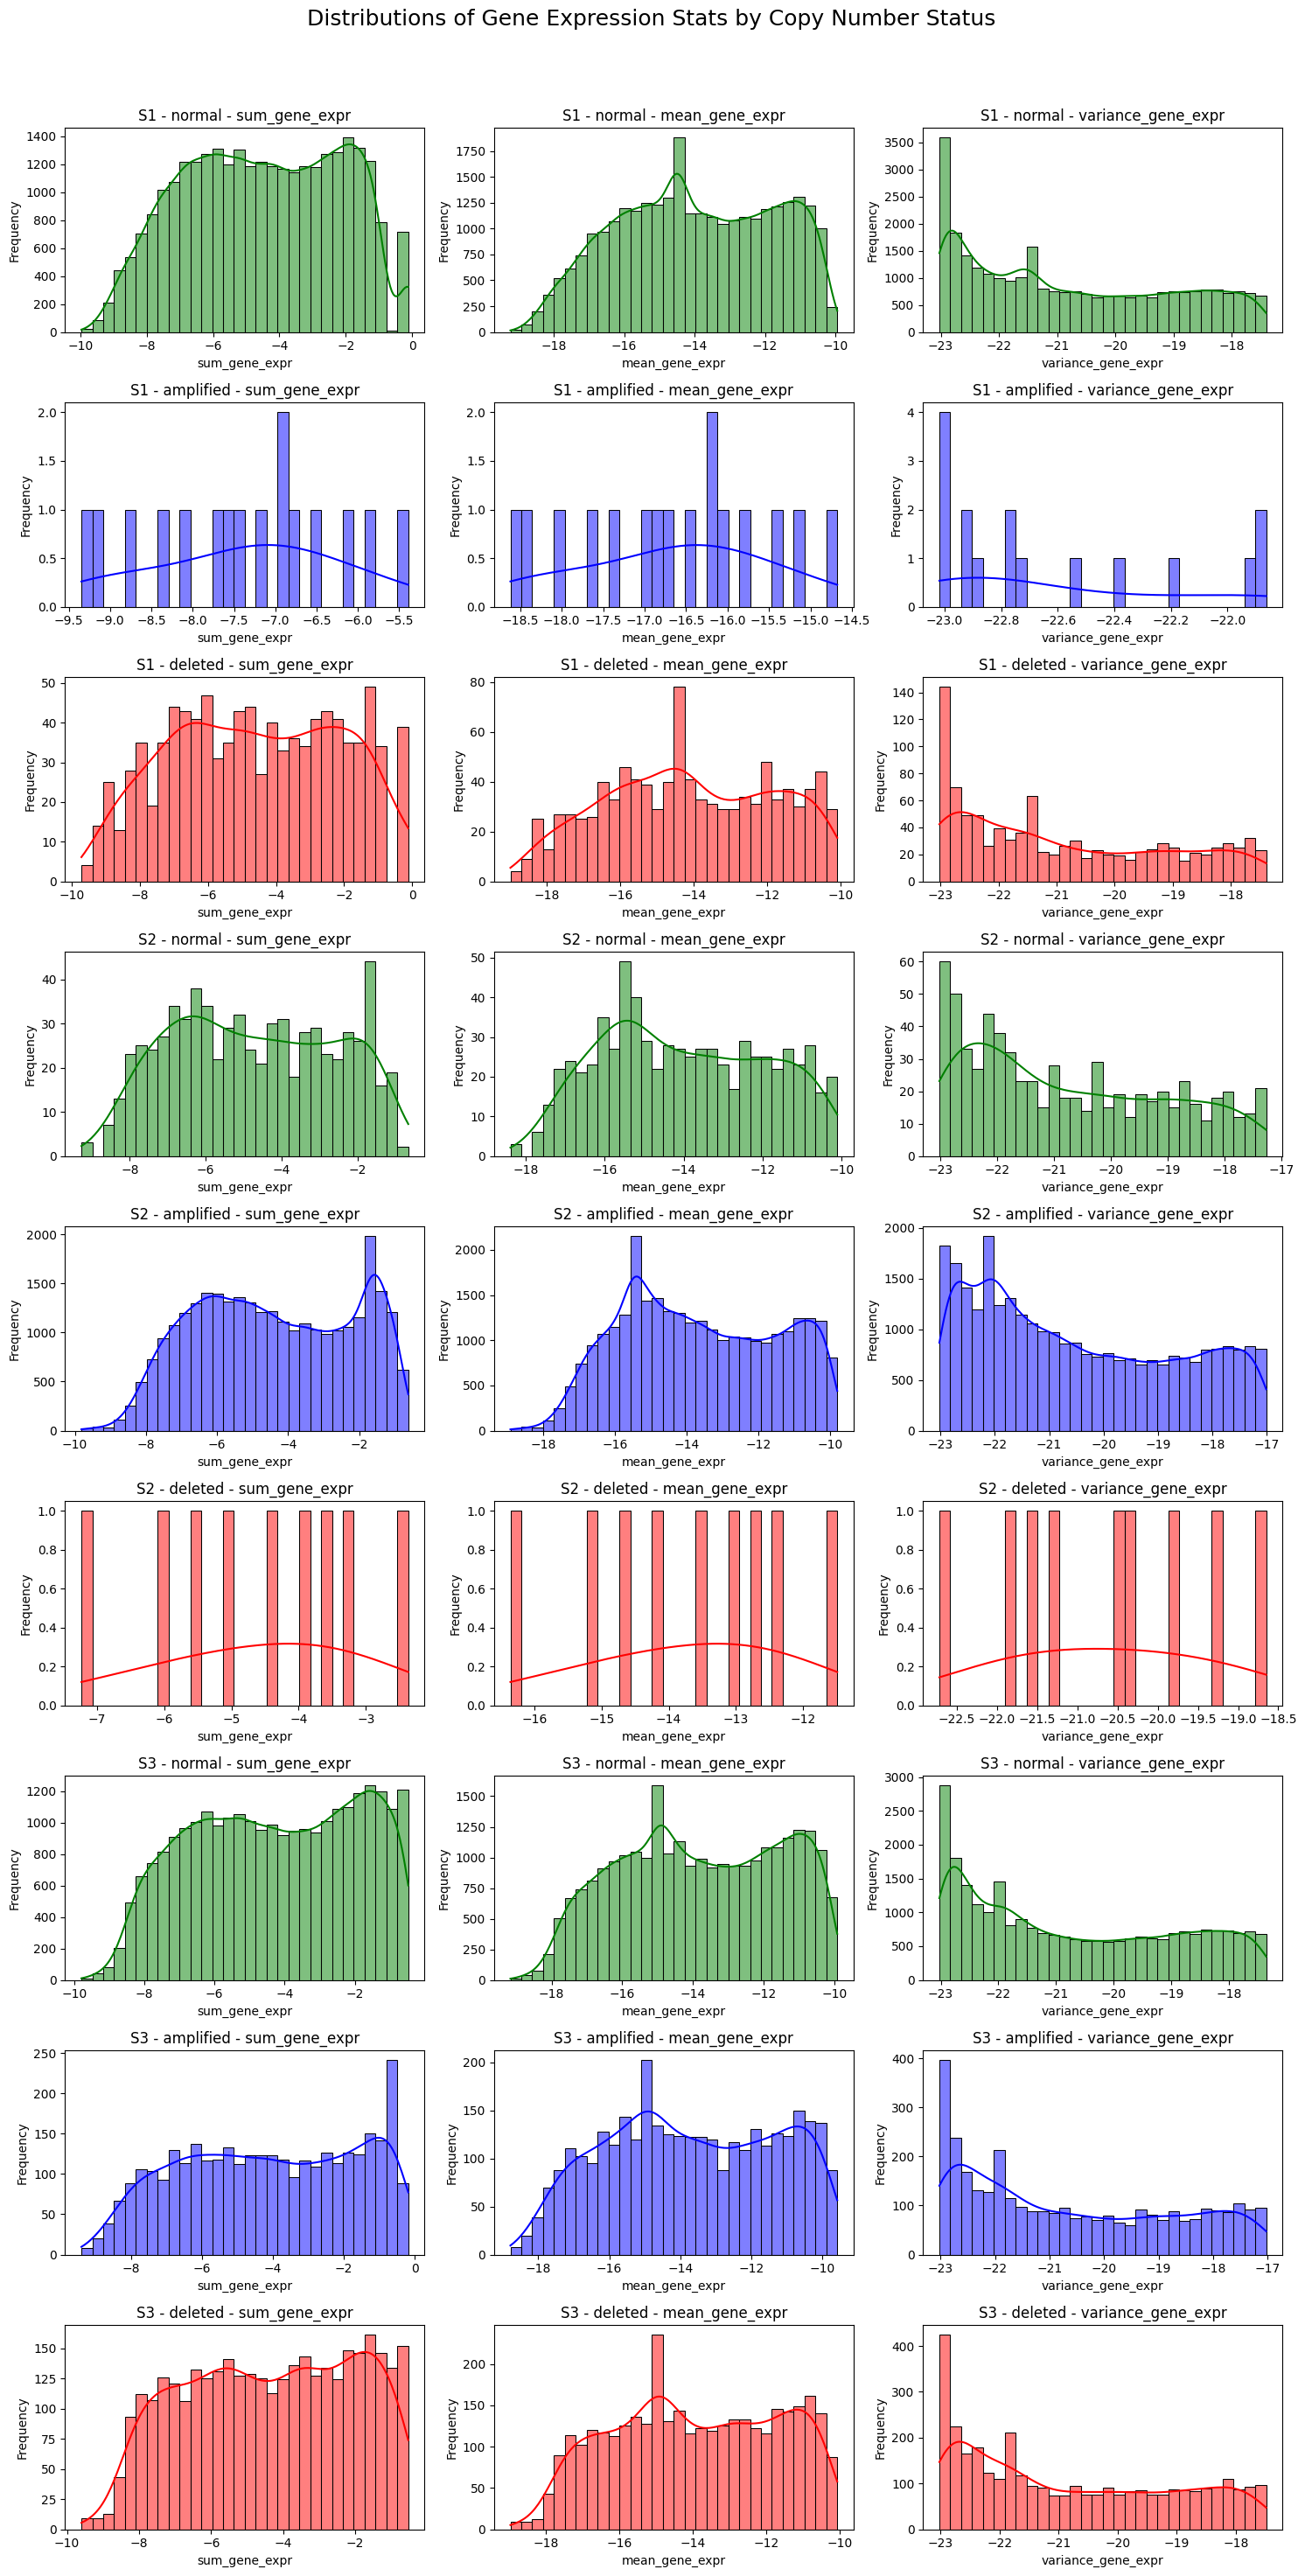

In [8]:
split_stats = {} # dictionary to hold

# 9x3 grid of subplots for 27 plots total
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
fig.suptitle('Distributions of Gene Expression Stats by Copy Number Status', fontsize=18)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    for column in stats:
        norm_df_cleaned = norm_df.copy()
        norm_df_cleaned = remove_outliers_iqr(norm_df_cleaned, column)
        amp_df_cleaned = amp_df.copy()
        amp_df_cleaned = remove_outliers_iqr(amp_df_cleaned, column)
        del_df_cleaned = del_df.copy()
        del_df_cleaned = remove_outliers_iqr(del_df_cleaned, column)

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    status_dfs_cleaned = [norm_df_cleaned, amp_df_cleaned, del_df_cleaned]
    statuses = ["normal", "amplified", "deleted"]

    # for each status-specific df, create histograms for each statistic
    for j, (status_df, status) in enumerate(zip(status_dfs_cleaned, statuses)):
        for k, stat in enumerate(stats):
            data = np.log(status_df[stat] + 1e-10) # small constant for zero values
            split_stats[f'{sample_name}_{status}_{stat}'] = data

            sns.histplot(data, bins=30, kde=True, ax=axes[i * 3 + j, k], color=status_colors[status])
            axes[i * 3 + j, k].set_title(f"{sample_name.upper()} - {status} - {stat}")
            axes[i * 3 + j, k].set_xlabel(stat)
            axes[i * 3 + j, k].set_ylabel("Frequency")

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()

### K-S Tests

Two-sample K-S tests are used to compare distributions. Statistics from sample 3 are examined. Despite its class imbalance, it has a significant amount of each class compared to other samples (of the chosen three in this notebook, and the dataset in general)

**K-S Test output terms**:

`statistic`: Maximum distance between the two cumulative distribution functions (CDFs). Higher value --> greater divergence.

`pvalue`: Probability of observing the given statistic under the null hypothesis
- Low p-value (e.g., < 0.05) suggests the two distributions are significantly different.
- High p-value means the distributions are similar enough to not reject the null hypothesis.

`statistic_location`: Value in the dataset where the maximum difference (statistic) occurs. Helps show where the two distributions deviate the most.

`statistic_sign`:
- -1: Indicates the CDF of dataset 1 is *below* that of dataset 2 at statistic_location.
- 1: Indicates the CDF of dataset 1 is *above* that of dataset 2 at statistic_location.

#### Deleted vs non-deleted

In [17]:
# sum comparison
ks_s3_sum_del_amp = ks_2samp(split_stats['s3_deleted_sum_gene_expr'], split_stats['s3_amplified_sum_gene_expr'])
print(f"K-S test (SUM - del vs amp):\n{ks_s3_sum_del_amp}")

ks_s3_sum_del_norm = ks_2samp(split_stats['s3_deleted_sum_gene_expr'], split_stats['s3_normal_sum_gene_expr'])
print(f"\nK-S test (SUM - del vs norm):\n{ks_s3_sum_del_norm}")

# mean comparison
ks_s3_mean_del_amp = ks_2samp(split_stats['s3_deleted_mean_gene_expr'], split_stats['s3_amplified_mean_gene_expr'])
print(f"\nK-S test (MEAN - del vs amp):\n{ks_s3_mean_del_amp}")

ks_s3_mean_del_norm = ks_2samp(split_stats['s3_deleted_mean_gene_expr'], split_stats['s3_normal_mean_gene_expr'])
print(f"\nK-S test (MEAN - del vs norm):\n{ks_s3_mean_del_norm}")

# variance comparison
ks_s3_variance_del_amp = ks_2samp(split_stats['s3_deleted_variance_gene_expr'], split_stats['s3_amplified_variance_gene_expr'])
print(f"\nK-S test (VARIANCE - del vs amp):\n{ks_s3_variance_del_amp}")

ks_s3_variance_del_norm = ks_2samp(split_stats['s3_deleted_variance_gene_expr'], split_stats['s3_normal_variance_gene_expr'])
print(f"\nK-S test (VARIANCE - del vs norm):\n{ks_s3_variance_del_norm}")

K-S test (SUM - del vs amp):
KstestResult(statistic=0.06594206538902016, pvalue=8.040266974800284e-07, statistic_location=-1.3182358532978198, statistic_sign=1)

K-S test (SUM - del vs norm):
KstestResult(statistic=0.02021745287827592, pvalue=0.16509976916698543, statistic_location=-3.0892665308270457, statistic_sign=1)

K-S test (MEAN - del vs amp):
KstestResult(statistic=0.06822111145902499, pvalue=2.858519968264337e-07, statistic_location=-10.710393175464189, statistic_sign=1)

K-S test (MEAN - del vs norm):
KstestResult(statistic=0.02680713194829165, pvalue=0.025079439657216818, statistic_location=-12.481401997117757, statistic_sign=1)

K-S test (VARIANCE - del vs amp):
KstestResult(statistic=0.0686765863472436, pvalue=2.3149126801688733e-07, statistic_location=-17.497254177263525, statistic_sign=1)

K-S test (VARIANCE - del vs norm):
KstestResult(statistic=0.024388490851116496, pvalue=0.05325929202224644, statistic_location=-19.490126771713967, statistic_sign=1)


**Observations**:
- **del vs amp** show higher `statistic` values (moderately different) and very low `pvalue` (significantly different) in general.
- **del vs normal** show lower `statistic` values (moderately different) and higher or moderate `pvalue` (not significantly different) which varies between different gene expression statistics.
- TODO: `statistic_sign` is 1 --> del has higher CDF at point of greatest diff between the 2 dist. for both amp and norm
- TODO: `statistic_location`
- Based on `statistic` and `pvalue`, deleted statuses have significantly different distributions to amplified ones, while not differing as much from normal ones.
- TODO: study/expand on meaning of a difference in distribution

#### Normal vs amplified

In [18]:
# sum comparison
ks_s3_sum_norm_amp = ks_2samp(split_stats['s3_normal_sum_gene_expr'], split_stats['s3_amplified_sum_gene_expr'])
print(f"K-S test (SUM - norm vs amp):\n{ks_s3_sum_norm_amp}")

# mean comparison
ks_s3_mean_norm_amp = ks_2samp(split_stats['s3_normal_mean_gene_expr'], split_stats['s3_amplified_mean_gene_expr'])
print(f"\nK-S test (MEAN - norm vs amp):\n{ks_s3_mean_norm_amp}")

# variance comparison
ks_s3_variance_norm_amp = ks_2samp(split_stats['s3_normal_variance_gene_expr'], split_stats['s3_amplified_variance_gene_expr'])
print(f"\nK-S test (VARIANCE - norm vs amp):\n{ks_s3_variance_norm_amp}")

K-S test (SUM - norm vs amp):
KstestResult(statistic=0.0544512131485686, pvalue=5.3707303414384816e-08, statistic_location=-0.9947856960728862, statistic_sign=1)

K-S test (MEAN - norm vs amp):
KstestResult(statistic=0.04940413573532332, pvalue=1.169227245889512e-06, statistic_location=-10.386944256725776, statistic_sign=1)

K-S test (VARIANCE - norm vs amp):
KstestResult(statistic=0.05074739049548893, pvalue=5.303310401141318e-07, statistic_location=-17.48843742986055, statistic_sign=1)


**Observations**: TODO
- `statistic` and `pvalue` (definitely different)
- `statistic_location`
- `statistic_sign`
- overall
- meaning/conclusion

## Deviance of statistics compared to mean over other samples

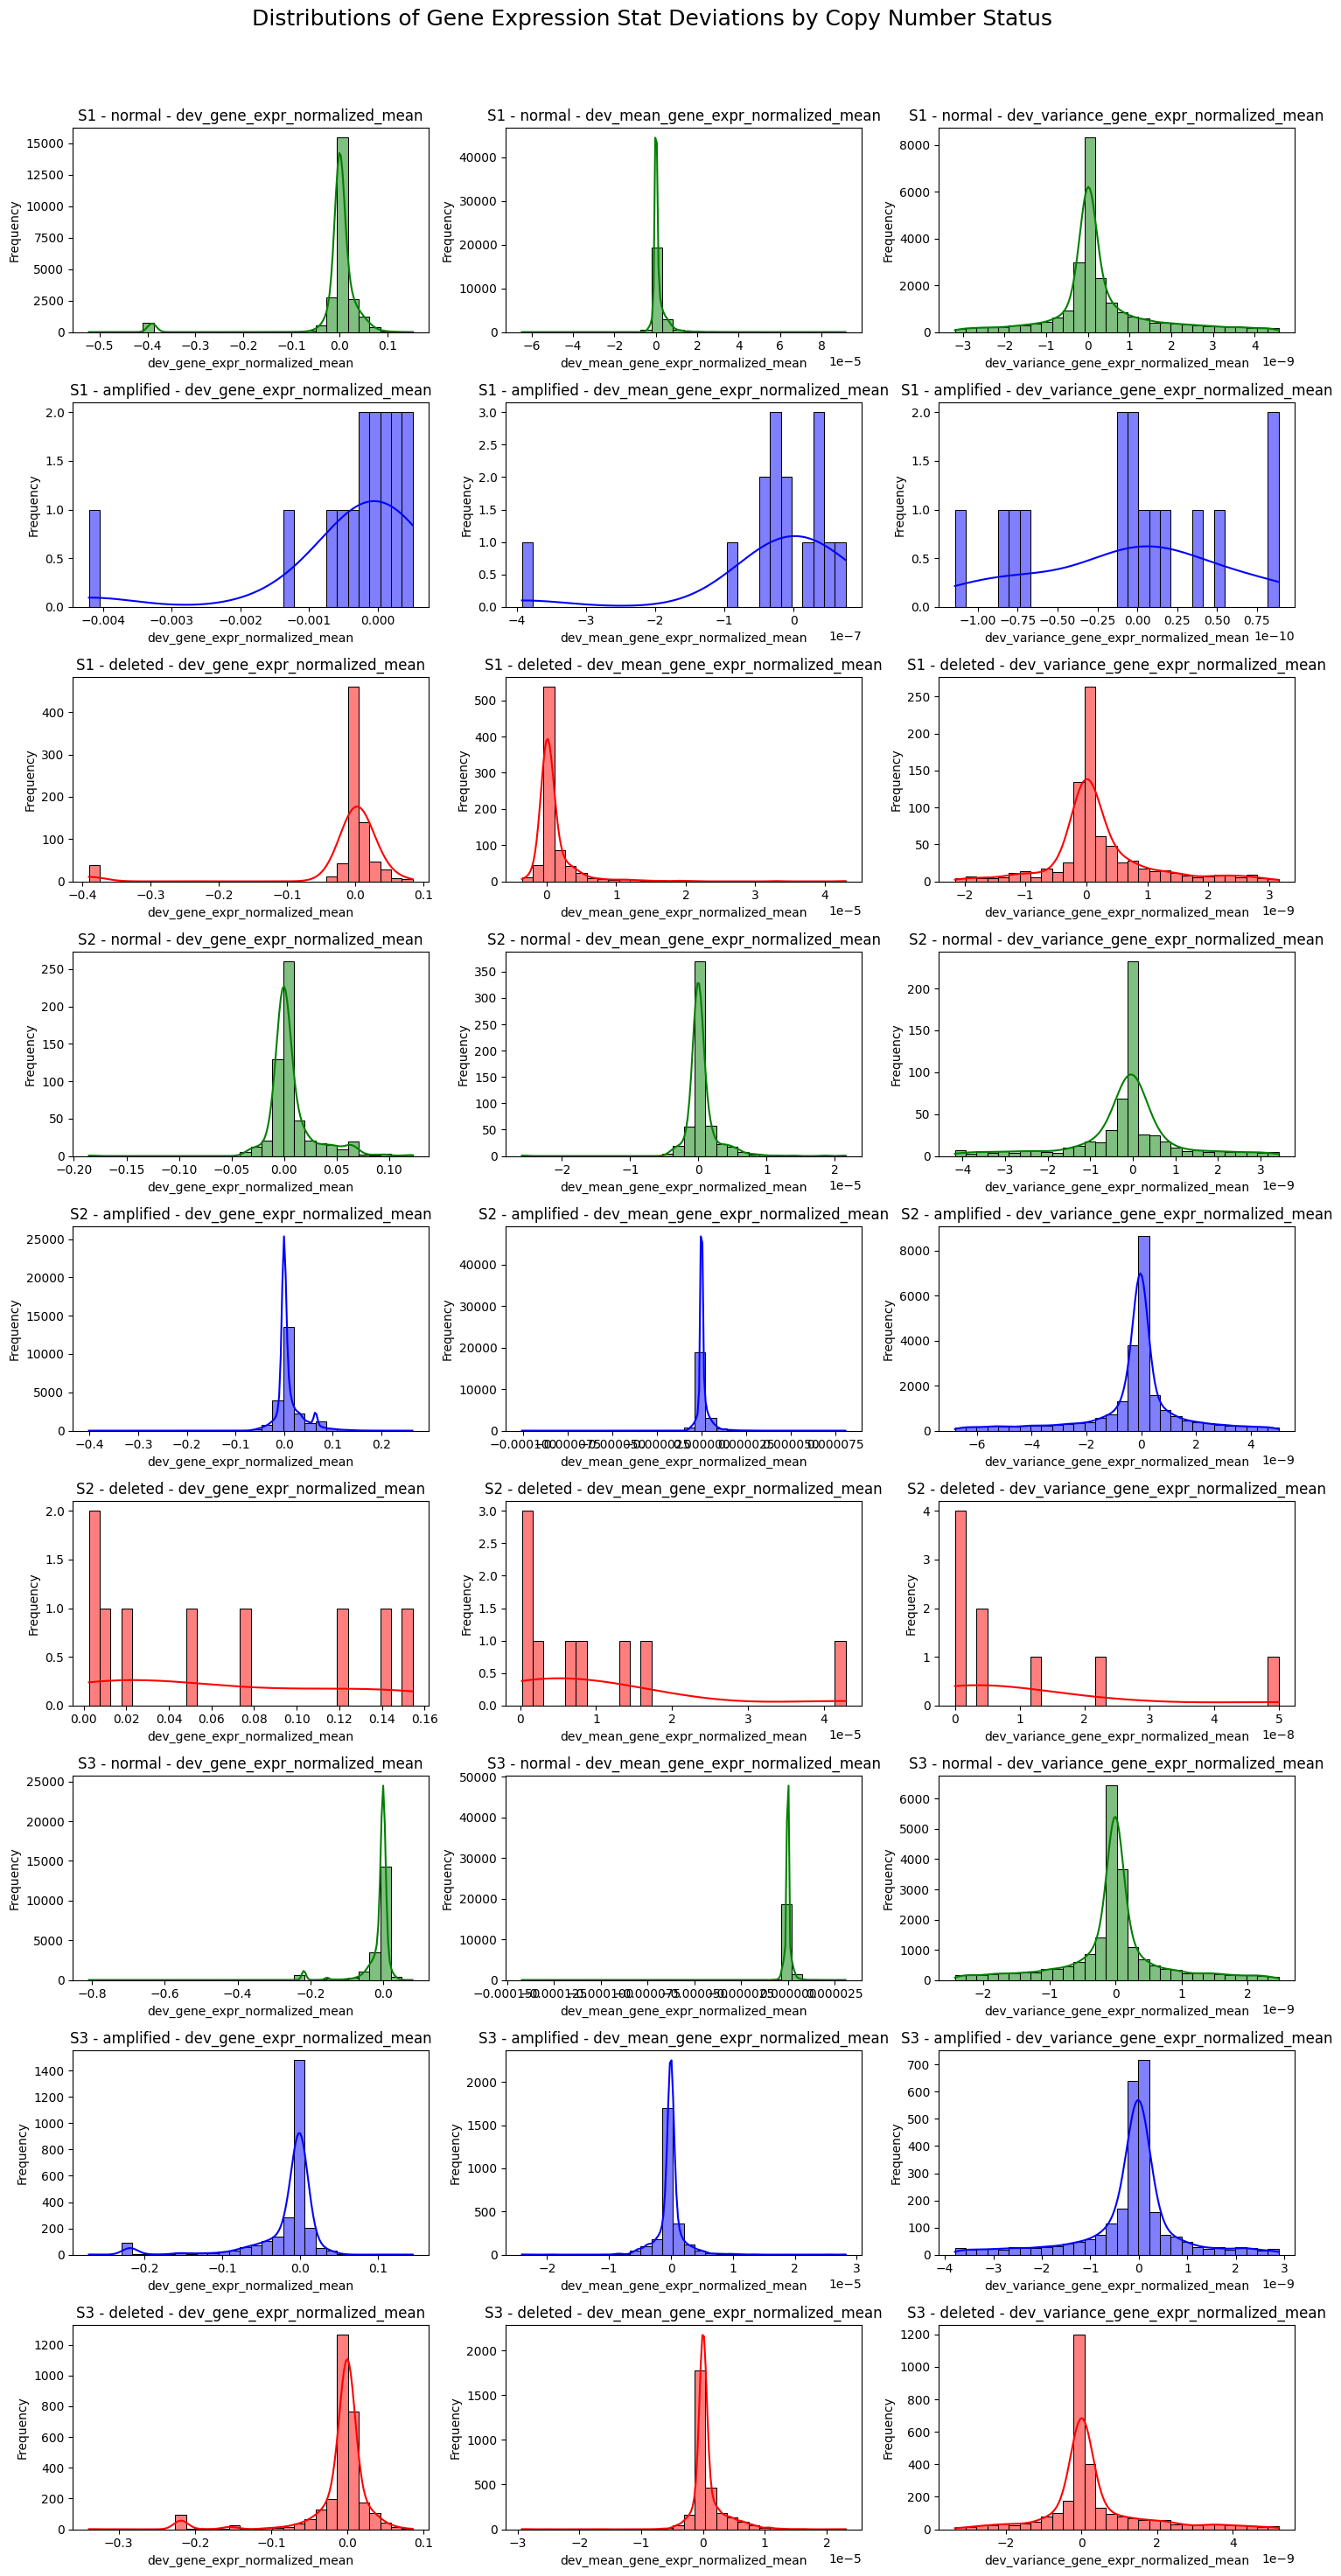

In [6]:
# 9x3 grid of subplots for 27 plots total
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
fig.suptitle('Distributions of Gene Expression Stat Deviations by Copy Number Status', fontsize=18)

for i, (sample_df, sample_name) in enumerate(zip(samples, sample_names)):
    # split each df by status
    norm_df = sample_df[sample_df['status'] == 'normal']
    amp_df = sample_df[sample_df['status'] == 'amplified']
    del_df = sample_df[sample_df['status'] == 'deleted']

    for column in dev_stats:
        norm_df_cleaned = norm_df.copy()
        norm_df_cleaned = remove_outliers_iqr(norm_df_cleaned, column)
        amp_df_cleaned = amp_df.copy()
        amp_df_cleaned = remove_outliers_iqr(amp_df_cleaned, column)
        del_df_cleaned = del_df.copy()
        del_df_cleaned = remove_outliers_iqr(del_df_cleaned, column)

    # lists of data and titles
    status_dfs = [norm_df, amp_df, del_df]
    status_dfs_cleaned = [norm_df_cleaned, amp_df_cleaned, del_df_cleaned]
    statuses = ["normal", "amplified", "deleted"]

    # for each status-specific df, create histograms for each statistic
    for j, (status_df, status) in enumerate(zip(status_dfs_cleaned, statuses)):
        for k, stat in enumerate(dev_stats):
            data = status_df[stat]

            sns.histplot(data, bins=30, kde=True, ax=axes[i * 3 + j, k], color=status_colors[status])
            axes[i * 3 + j, k].set_title(f"{sample_name.upper()} - {status} - {stat}")
            axes[i * 3 + j, k].set_xlabel(stat)
            axes[i * 3 + j, k].set_ylabel("Frequency")

# prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjusts layout to fit within figure area with title
plt.show()